# Intent Classification using LSTM



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Intent_datasets/

/content/drive/.shortcut-targets-by-id/1hiSbEsD7D04nlYfvIW5ZZy6OaI57PR1U/Intent_datasets


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
import tensorflow as tf


import pandas as pd
import numpy as np
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk

from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize


from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Preparation

In [6]:
df_ins = pd.read_json("is_train.json")
print (len(df_ins))

15000


In [7]:
#Columns and datatypes
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       15000 non-null  object
 1   1       15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


# Undersampling

In [8]:
# select 10 records from each specific intents
df_ins = df_ins.groupby(1).sample(10).reset_index(drop=True)
print (len(df_ins))

1500


In [9]:
df_ins[1] = "ins"

In [10]:
df_oos_train = pd.read_json("oos_train.json")
df_oos_val = pd.read_json("oos_val.json")
df_oos_test = pd.read_json("oos_test.json")

df_oos = df_oos_train.append(df_oos_val).append(df_oos_test)

# Merge in_scope and out-scope data
df = df_ins.append(df_oos)





In [11]:
category_count = df[1].value_counts()

categories = category_count.index

categories

Index(['ins', 'oos'], dtype='object')

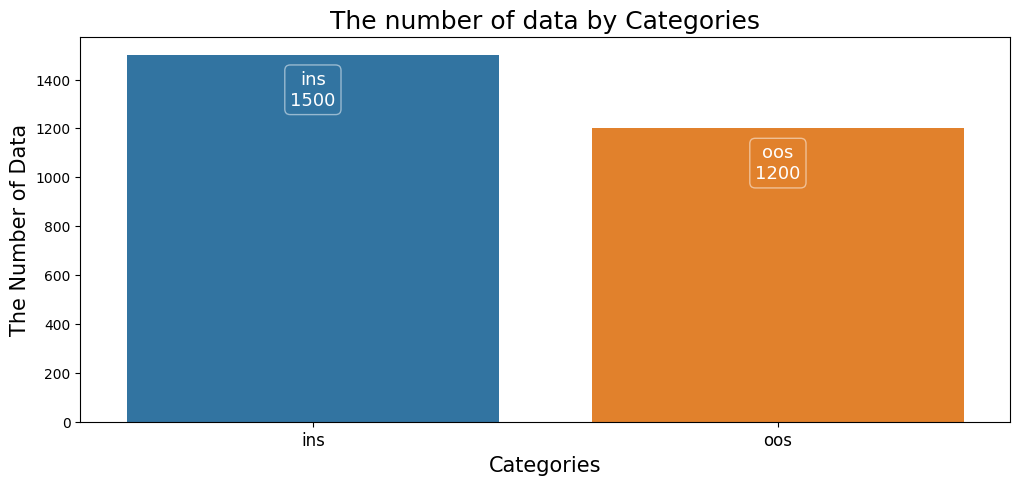

In [12]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Data', size= 15)

plt.xticks(size = 12)

plt.title("The number of data by Categories" , size = 18)

plt.show()

#Convert labels to numeric

In [13]:
df[1].loc[df[1]=="ins"]=0
df[1].loc[df[1]=="oos"]=1


In [14]:
df.rename(columns={0 : 'Text', 1: 'Label'}, inplace=True)

In [15]:
df["Label"].value_counts()

0    1500
1    1200
Name: Label, dtype: int64

In [16]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def data_cleaning(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df["Text"] = df["Text"].apply(data_cleaning)

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df["Text"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3337 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2700, 250)


In [19]:
# Y = np.asarray(df['Label'])

Y = np.asarray(df['Label']).astype(np.float32)
print('Shape of label tensor:', Y.shape)



Shape of label tensor: (2700,)


# Train Test Split

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2430, 250) (2430,)
(270, 250) (270,)


# Model Definition

In [21]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(32, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          4000000   
                                                                 
 lstm (LSTM)                 (None, 250, 50)           30200     
                                                                 
 lstm_1 (LSTM)               (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,040,857
Trainable params: 4,040,857
Non-trainable params: 0
_________________________________________________________________
None


# Model Training

In [22]:
epochs = 40
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/40
35/35 [==============================] - 37s 853ms/step - loss: 0.6845 - accuracy: 0.5569 - val_loss: 0.6856 - val_accuracy: 0.5144
Epoch 2/40
35/35 [==============================] - 28s 789ms/step - loss: 0.6249 - accuracy: 0.6191 - val_loss: 0.5609 - val_accuracy: 0.6955
Epoch 3/40
35/35 [==============================] - 29s 841ms/step - loss: 0.3970 - accuracy: 0.8656 - val_loss: 0.4450 - val_accuracy: 0.7860
Epoch 4/40
35/35 [==============================] - 27s 774ms/step - loss: 0.1899 - accuracy: 0.9401 - val_loss: 0.3994 - val_accuracy: 0.8107
Epoch 5/40
35/35 [==============================] - 26s 742ms/step - loss: 0.1018 - accuracy: 0.9689 - val_loss: 0.4549 - val_accuracy: 0.8107
Epoch 6/40
35/35 [==============================] - 28s 780ms/step - loss: 0.0560 - accuracy: 0.9858 - val_loss: 0.4634 - val_accuracy: 0.8148
Epoch 7/40
35/35 [==============================] - 28s 792ms/step - loss: 0.0357 - accuracy: 0.9913 - val_loss: 0.5033 - val_accuracy: 0.8025

In [23]:
print (len(Y_test))

270


# Model Validation

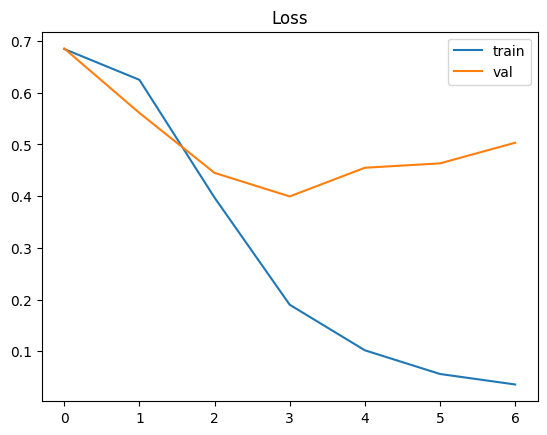

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

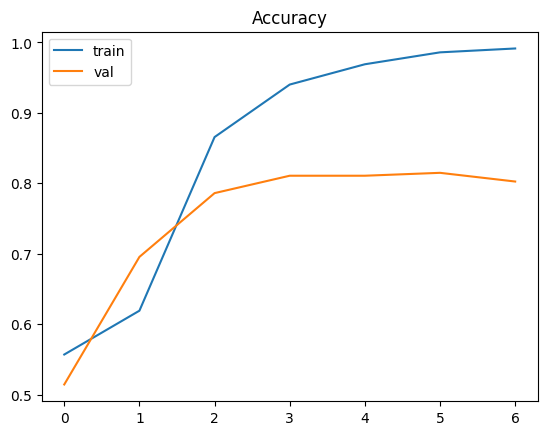

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();

In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9/9 [==============================] - 1s 81ms/step - loss: 0.4411 - accuracy: 0.8407
Test set
  Loss: 0.441
  Accuracy: 0.841


In [27]:
predictions = model.predict(X_test)
print (predictions[:5])

9/9 [==============================] - 1s 76ms/step
[[0.065842  ]
 [0.01504491]
 [0.98888016]
 [0.47322208]
 [0.05671247]]


In [28]:
y_pred = []

for element in predictions:
  if element > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Y_test, y_pred)
cm 

array([[134,  21],
       [ 22,  93]])

#Confusion Matrix

Text(50.722222222222214, 0.5, 'Truth')

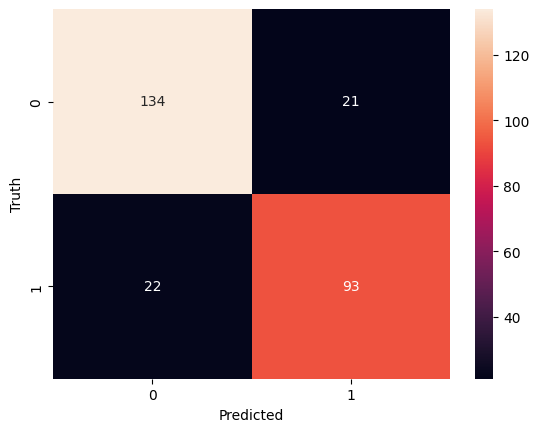

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

In [32]:
r_probs = [0 for _ in range(len(Y_test))]

In [33]:
r_auc = roc_auc_score(Y_test, r_probs)
lstM_auc = roc_auc_score(Y_test, predictions)


In [34]:
l_fpr , l_tpr, _  = roc_curve(Y_test, predictions)
fpr, tpr, _ = roc_curve(Y_test, r_probs)


#ROC-AUC CURVE

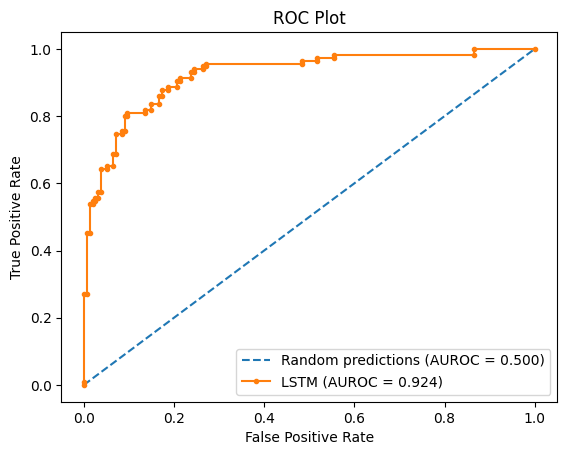

In [35]:
# plt.plot(fpr, tpr, linestyle='.', label='Prediction (AUROC = %0.3f)' % r_auc)
# plt.plot(l_fpr, l_tpr, marker='__', label='Random Forest (AUROC = %0.3f)' % lstM_auc)

plt.plot(fpr, tpr, linestyle='--', label='Random predictions (AUROC = %0.3f)' % r_auc)
plt.plot(l_fpr, l_tpr, marker='.', label='LSTM (AUROC = %0.3f)' % lstM_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Saving & Loading the model

# Loading Pre-Trained Model

In [36]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       155
         1.0       0.82      0.81      0.81       115

    accuracy                           0.84       270
   macro avg       0.84      0.84      0.84       270
weighted avg       0.84      0.84      0.84       270

